In [1]:
import polars as pl
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm, bernoulli


In [2]:
# Even cleaner approach: One-liner using list comprehension
df_clean = pl.DataFrame([line.split() for line in open("riverside_2025.txt", "r")], 
                       schema=['treatment', 'earnings1', 'earnings4', 'highschool', 'female', 'age', 'smallchild', 'single'],  # Give meaningful column names
                       orient="row")

# Convert all columns to float (they're strings by default from split())
df_clean = df_clean.with_columns(pl.all().cast(pl.Float64))

print(df_clean)

shape: (5_419, 8)
┌───────────┬───────────┬───────────┬────────────┬────────┬──────┬────────────┬────────┐
│ treatment ┆ earnings1 ┆ earnings4 ┆ highschool ┆ female ┆ age  ┆ smallchild ┆ single │
│ ---       ┆ ---       ┆ ---       ┆ ---        ┆ ---    ┆ ---  ┆ ---        ┆ ---    │
│ f64       ┆ f64       ┆ f64       ┆ f64        ┆ f64    ┆ f64  ┆ f64        ┆ f64    │
╞═══════════╪═══════════╪═══════════╪════════════╪════════╪══════╪════════════╪════════╡
│ 0.0       ┆ 0.264     ┆ 0.0       ┆ 0.0        ┆ 1.0    ┆ 38.0 ┆ 0.0        ┆ 1.0    │
│ 1.0       ┆ 2.4314    ┆ 0.8484    ┆ 1.0        ┆ 1.0    ┆ 34.0 ┆ 0.0        ┆ 1.0    │
│ 1.0       ┆ 1.744     ┆ 0.0       ┆ 1.0        ┆ 0.0    ┆ 38.0 ┆ 0.0        ┆ 1.0    │
│ 1.0       ┆ 0.0       ┆ 22.9053   ┆ 1.0        ┆ 1.0    ┆ 23.0 ┆ 1.0        ┆ 1.0    │
│ 1.0       ┆ 0.0       ┆ 8.1741    ┆ 1.0        ┆ 1.0    ┆ 40.0 ┆ 0.0        ┆ 1.0    │
│ …         ┆ …         ┆ …         ┆ …          ┆ …      ┆ …    ┆ …          ┆ …      │
│ 1

(array([3.023e+03, 4.060e+02, 2.750e+02, 1.890e+02, 1.720e+02, 1.140e+02,
        7.200e+01, 4.100e+01, 2.300e+01, 8.000e+00, 1.200e+01, 7.000e+00,
        6.000e+00, 5.000e+00, 5.000e+00, 4.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
        26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
        52., 54., 56., 58., 60.]),
 <BarContainer object of 30 artists>)

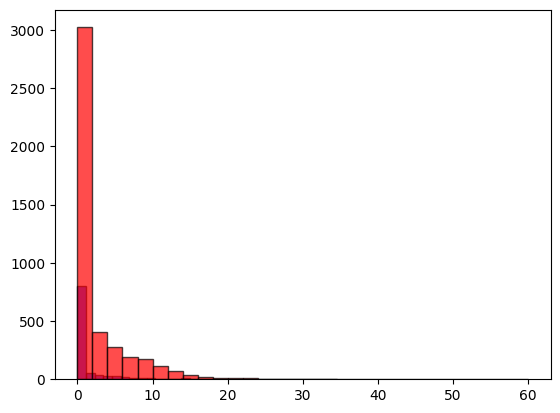

In [6]:
plt.hist(df_clean.filter(pl.col('treatment') == 0)['earnings1'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.hist(df_clean.filter(pl.col('treatment') == 1)['earnings1'], bins=30, alpha=0.7, color='red', edgecolor='black')

In [42]:
df_clean.height

5419

# Section 1 (A, B, C)

In [61]:
K = 10000 # Number of simulations
n = df_clean.height # Number of observations
m = df_clean.filter(pl.col('treatment') == 1).height # Number of treated observations

test_statistics1 = []
test_statistics2 = []
test_statistics3 = []


for i in range(K):

    binary_list = [1] * m + [0] * (n - m)
    random.shuffle(binary_list)

    sim_df = df_clean.with_columns(pl.Series("sim_treatment", binary_list))

    test_statistics1.append(sim_df.filter(pl.col('sim_treatment') == 1)['earnings1'].mean() -
                      sim_df.filter(pl.col('sim_treatment') == 0)['earnings1'].mean())

    test_statistics2.append(sim_df.filter(pl.col('sim_treatment') == 1)['earnings1'].median() -
                      sim_df.filter(pl.col('sim_treatment') == 0)['earnings1'].median())

    test_statistics3.append(sim_df.filter(pl.col('sim_treatment') == 1)['earnings1'].var() /
                      sim_df.filter(pl.col('sim_treatment') == 0)['earnings1'].var())



observed_statistic1 = (df_clean.filter(pl.col('treatment') == 1)['earnings1'].mean() -
                      df_clean.filter(pl.col('treatment') == 0)['earnings1'].mean())

observed_statistic2 = (df_clean.filter(pl.col('treatment') == 1)['earnings1'].median() -
                      df_clean.filter(pl.col('treatment') == 0)['earnings1'].median())

observed_statistic3 = (df_clean.filter(pl.col('treatment') == 1)['earnings1'].var() /
                      df_clean.filter(pl.col('treatment') == 0)['earnings1'].var())


In [66]:
p_value_1 = (np.abs(test_statistics1) >= np.abs(observed_statistic1)).mean()
p_value_2 = (np.abs(test_statistics2) >= np.abs(observed_statistic2)).mean()
p_value_3 = (np.abs(test_statistics3) >= np.abs(observed_statistic3)).mean()


print(f"Observed Test Statistic 1: {observed_statistic1}")
print(f"P-value 1: {p_value_1}")

print(f"Observed Test Statistic 2: {observed_statistic2}")
print(f"P-value 2: {p_value_2}")

print(f"Observed Test Statistic 3: {observed_statistic3}")
print(f"P-value 3: {p_value_3}")

Observed Test Statistic 1: 1.13621021012212
P-value 1: 0.0
Observed Test Statistic 2: 0.019
P-value 2: 0.015
Observed Test Statistic 3: 2.2257718315313038
P-value 3: 0.0001


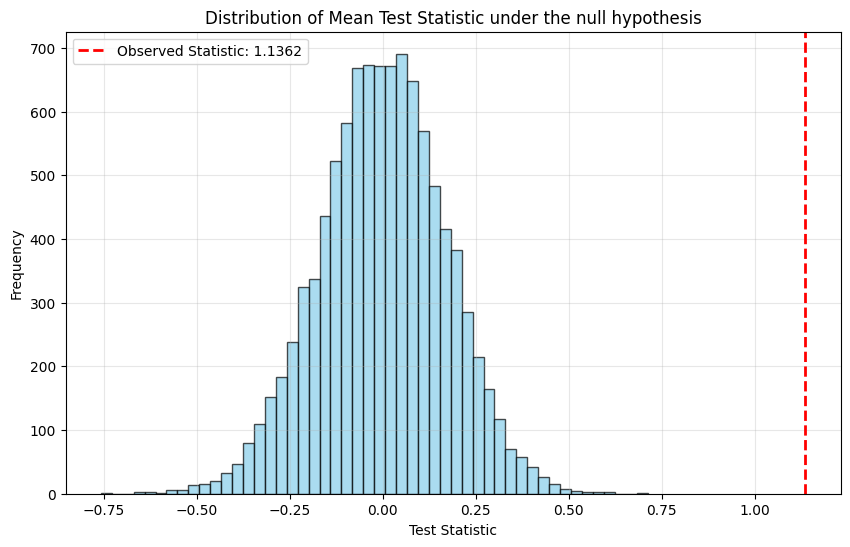

In [67]:
plt.figure(figsize=(10, 6))
plt.hist(test_statistics1, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(observed_statistic1, color='red', linestyle='--', linewidth=2, label=f'Observed Statistic: {observed_statistic1:.4f}')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Test Statistic under the null hypothesis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('stat1_graph.png', dpi=300, bbox_inches='tight')
plt.show()

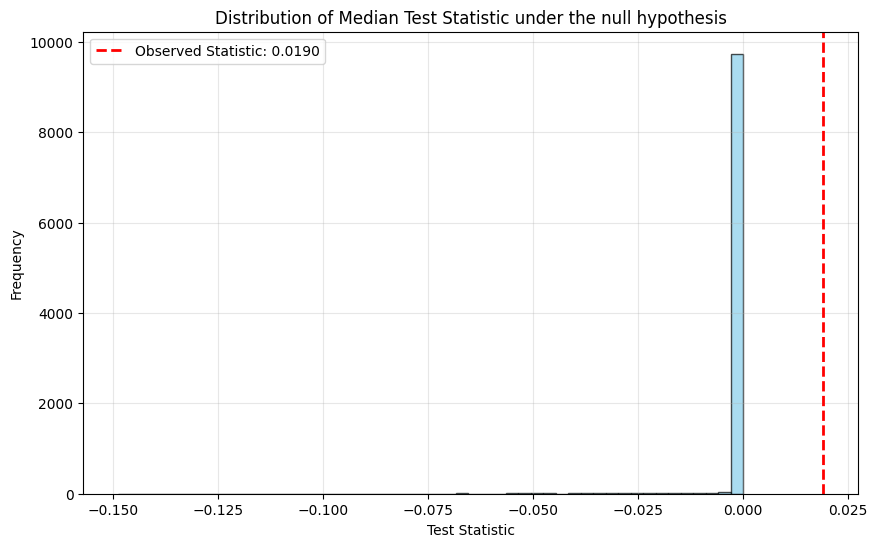

In [68]:
plt.figure(figsize=(10, 6))
plt.hist(test_statistics2, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(observed_statistic2, color='red', linestyle='--', linewidth=2, label=f'Observed Statistic: {observed_statistic2:.4f}')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Median Test Statistic under the null hypothesis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('stat2_graph.png', dpi=300, bbox_inches='tight')
plt.show()

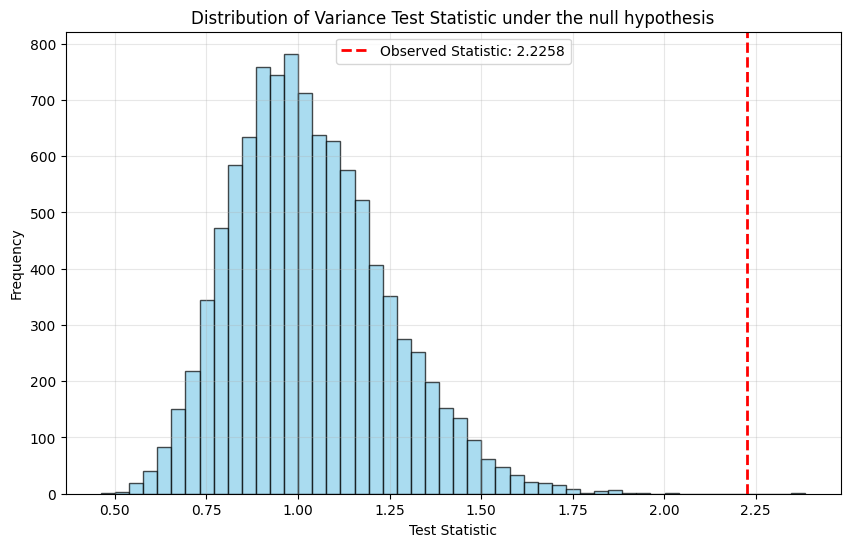

In [69]:
plt.figure(figsize=(10, 6))
plt.hist(test_statistics3, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(observed_statistic3, color='red', linestyle='--', linewidth=2, label=f'Observed Statistic: {observed_statistic3:.4f}')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Variance Test Statistic under the null hypothesis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('stat3_graph.png', dpi=300, bbox_inches='tight')
plt.show()


# Section 1 (D)

In [56]:
K = 10000 # Number of simulations
n = df_clean.height # Number of observations
m = df_clean.filter(pl.col('treatment') == 1).height # Number of treated observations

test_statistics1 = []
test_statistics2 = []
test_statistics3 = []


for i in range(K):

    binary_list = bernoulli.rvs(0.2, size=n)

    sim_df = df_clean.with_columns(pl.Series("sim_treatment", binary_list))

    test_statistics1.append(sim_df.filter(pl.col('sim_treatment') == 1)['earnings1'].mean() -
                      sim_df.filter(pl.col('sim_treatment') == 0)['earnings1'].mean())

    test_statistics2.append(sim_df.filter(pl.col('sim_treatment') == 1)['earnings1'].median() - # Polars median takes the average if list is even
                      sim_df.filter(pl.col('sim_treatment') == 0)['earnings1'].median())

    test_statistics3.append(sim_df.filter(pl.col('sim_treatment') == 1)['earnings1'].var() /
                      sim_df.filter(pl.col('sim_treatment') == 0)['earnings1'].var())

In [57]:
p_value_1 = (np.abs(test_statistics1) >= np.abs(observed_statistic1)).mean()
p_value_2 = (np.abs(test_statistics2) >= np.abs(observed_statistic2)).mean()
p_value_3 = (np.abs(test_statistics3) >= np.abs(observed_statistic3)).mean()


print(f"Observed Test Statistic 1: {observed_statistic1}")
print(f"P-value 1: {p_value_1}")

print(f"Observed Test Statistic 2: {observed_statistic2}")
print(f"P-value 2: {p_value_2}")

print(f"Observed Test Statistic 3: {observed_statistic3}")
print(f"P-value 3: {p_value_3}")

Observed Test Statistic 1: 1.13621021012212
P-value 1: 0.0
Observed Test Statistic 2: 0.019
P-value 2: 0.0143
Observed Test Statistic 3: 2.2257718315313038
P-value 3: 0.0


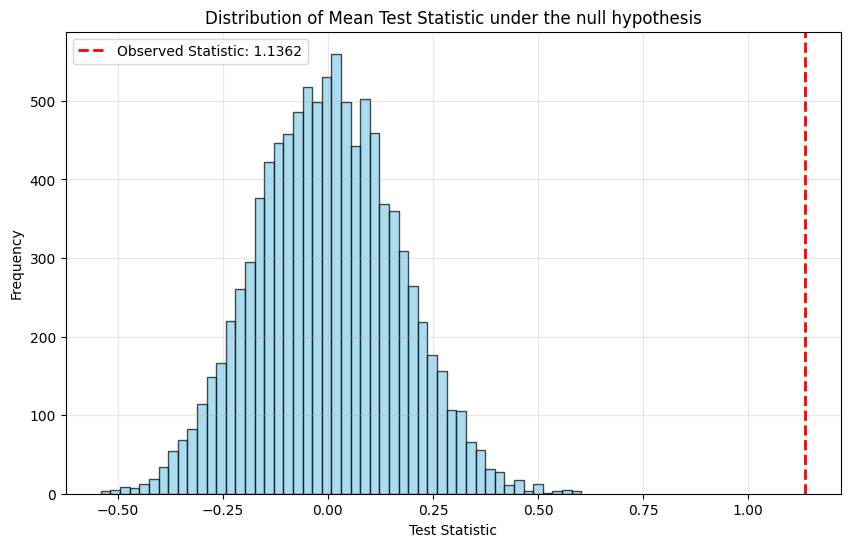

In [58]:
plt.figure(figsize=(10, 6))
plt.hist(test_statistics1, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(observed_statistic1, color='red', linestyle='--', linewidth=2, label=f'Observed Statistic: {observed_statistic1:.4f}')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Test Statistic under the null hypothesis')
plt.legend()
plt.grid(True, alpha=0.3)
#plt.savefig('stat1_graph.png', dpi=300, bbox_inches='tight')
plt.show()

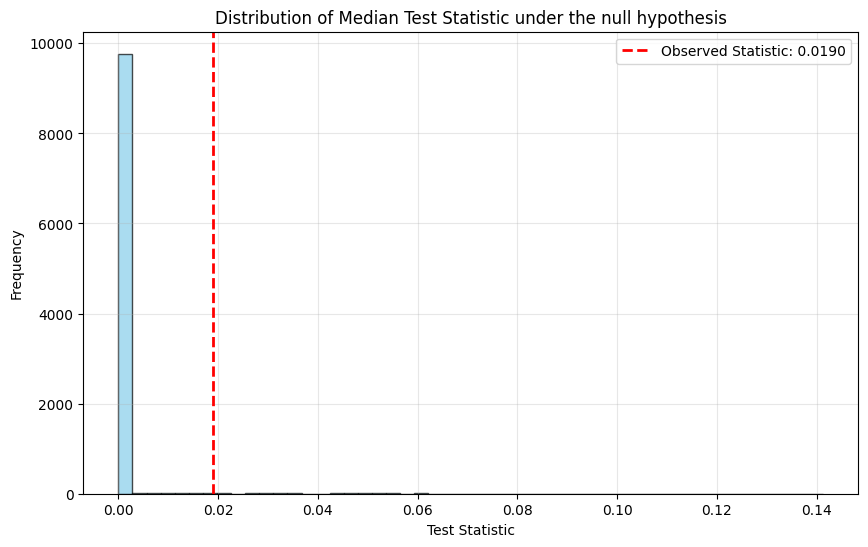

In [59]:
plt.figure(figsize=(10, 6))
plt.hist(test_statistics2, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(observed_statistic2, color='red', linestyle='--', linewidth=2, label=f'Observed Statistic: {observed_statistic2:.4f}')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Median Test Statistic under the null hypothesis')
plt.legend()
plt.grid(True, alpha=0.3)
#plt.savefig('stat2_graph.png', dpi=300, bbox_inches='tight')
plt.show()

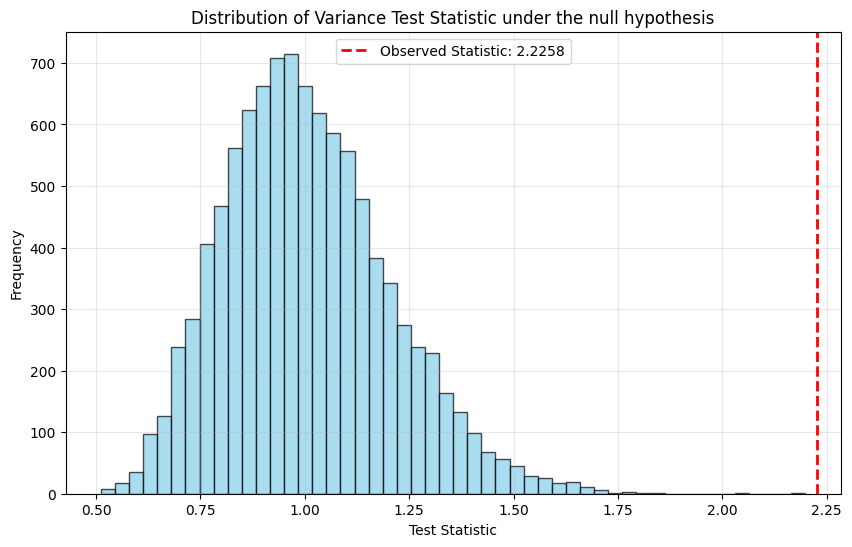

In [60]:
plt.figure(figsize=(10, 6))
plt.hist(test_statistics3, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(observed_statistic3, color='red', linestyle='--', linewidth=2, label=f'Observed Statistic: {observed_statistic3:.4f}')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Variance Test Statistic under the null hypothesis')
plt.legend()
plt.grid(True, alpha=0.3)
#plt.savefig('stat3_graph.png', dpi=300, bbox_inches='tight')
plt.show()
